# Assignment 1 - Q1 - Linear Regression with uncertainties in x

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# inline plot
%matplotlib inline
# default figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible
np.random.seed(42)
%config Completer.use_jedi = False

first, read the .parquet file using pyarrow and then convert to a pandas DataFrame

In [2]:
import pyarrow.parquet as pq
from pathlib import Path

data_path = Path('..') / 'data' / 'data1.parquet'  # assume there is a data folder in the parent path
data = pq.read_table(data_path, memory_map=True)
data = data.to_pandas()

analyze the data by sampling and visually in a scatter plot. look for outliers.

In [3]:
data.sample(5)

,x,y
30,-22.270835,176.877390
67,140.305469,393.162990
62,183.492552,490.940796
47,43.151928,84.575376
42,129.179171,472.954465


<AxesSubplot:title={'center':'data scattter plot with outliers'}, xlabel='x', ylabel='y'>

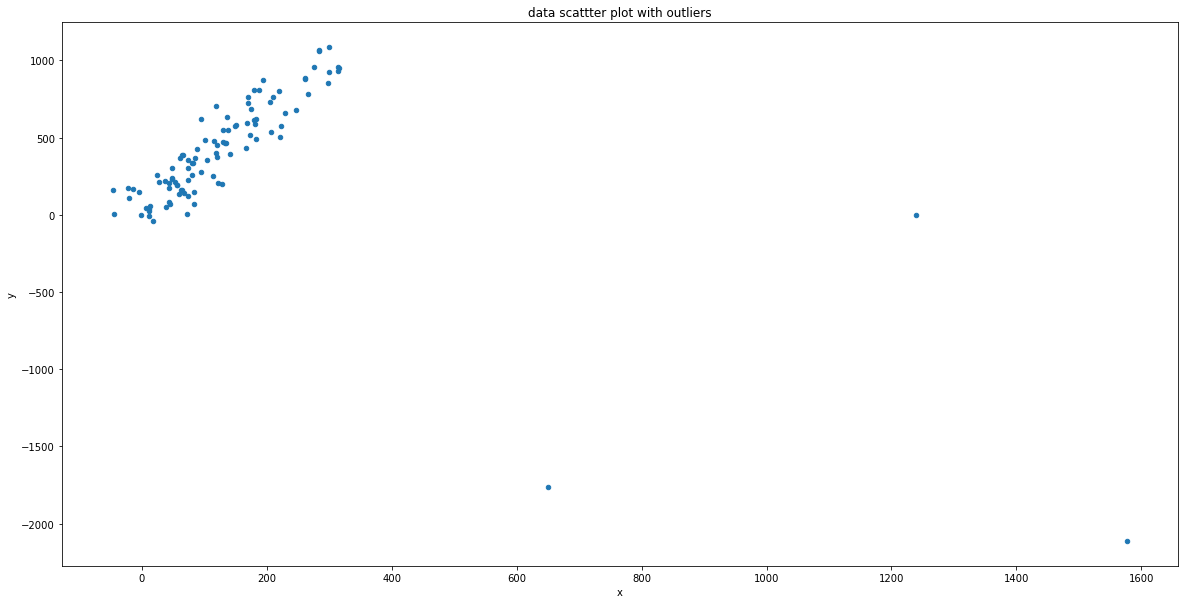

In [4]:
data.plot.scatter('x', 'y', title='data scattter plot with outliers')

we can get rid of the outliers by a simple cut-off on the x axis

In [5]:
x_cutoff = data.loc[(data.y < -1500) & (data.y > -2000)].x.iloc[0]
data = data.loc[data.x < x_cutoff]

scatter plot the data without outliers

<AxesSubplot:title={'center':'data scatter plot without outliers'}, xlabel='x', ylabel='y'>

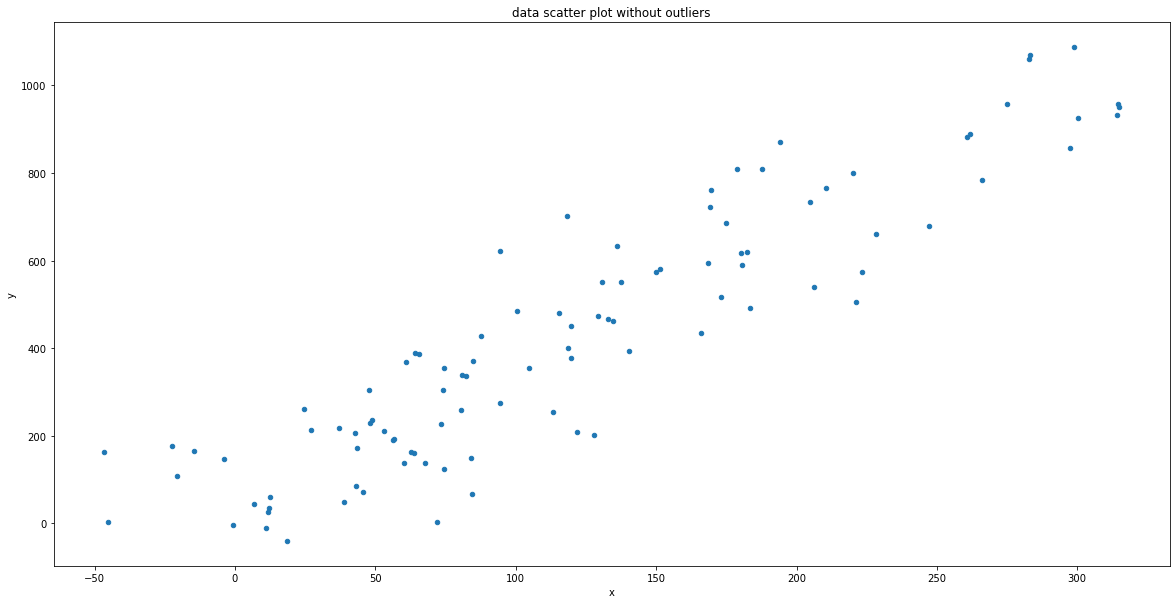

In [6]:
data.plot.scatter('x', 'y', title='data scatter plot without outliers')

now, try and fit a simple linear regressor

In [7]:
from sklearn.linear_model import LinearRegression
# include intercept
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(data.x.values.reshape(-1, 1), data.y)
f'y = {lin_reg.intercept_} + {lin_reg.coef_[0]} * x'

'y = 70.02365496350114 + 2.9735850481261794 * x'

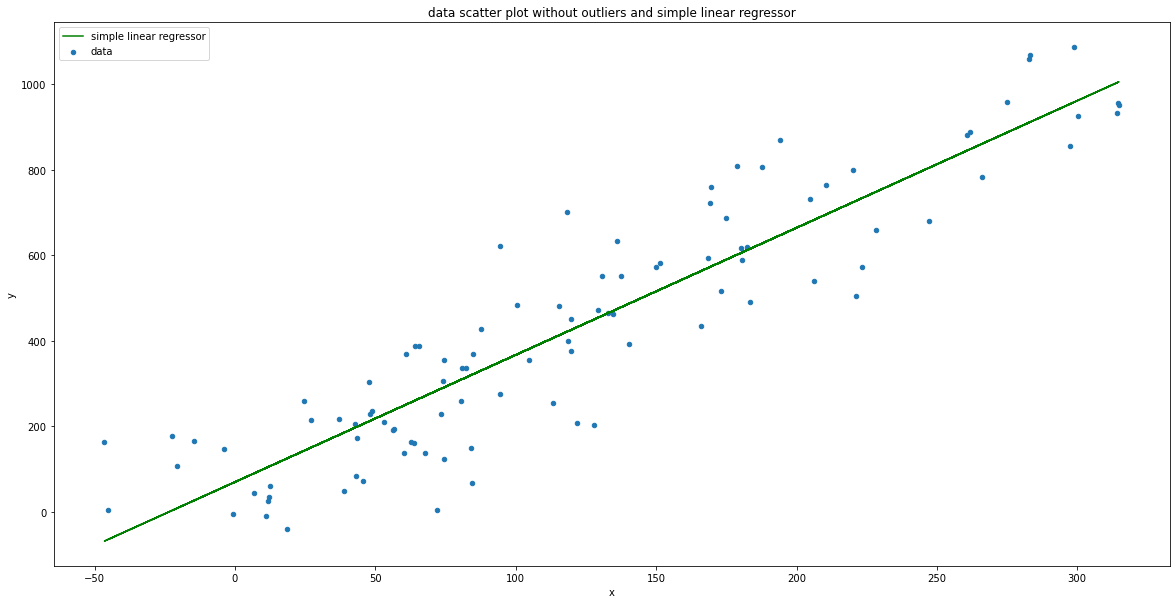

In [8]:
data.plot.scatter('x', 'y', title='data scatter plot without outliers and simple linear regressor', label='data')

plt.plot(data.x, lin_reg.predict(data.x.values.reshape(-1, 1)), "g-", label='simple linear regressor')
plt.legend(loc='upper left')
plt.show()

are the assumptions of linear regression correct? let's check it out.

Text(0.5, 1.0, 'Residuals vs. Fitted')

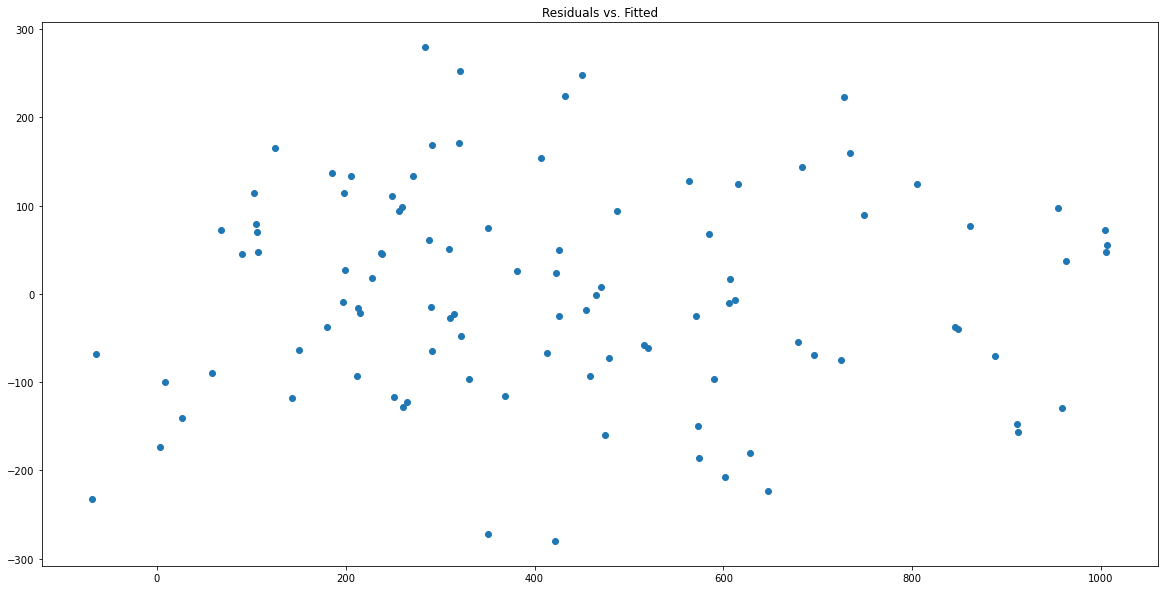

In [9]:
residuals = lin_reg.predict(data.x.values.reshape(-1, 1)) - data.y
plt.scatter(x=lin_reg.predict(data.x.values.reshape(-1, 1)), y=residuals)
plt.title('Residuals vs. Fitted')

there's no pattern "jumping to the eye" in the 'Residuals vs. Fitted' plot, it seems uncorrelated. thus, probably the relationship is truly linear, and there's no sign of "Heteroskedasticity".
also, it seems like there's no autocorrrelation in the residuals.
third point is that there's only one independent variable x here, so no multicolinearity.


perform a Shapiro-Wilks test to determine if the residuals are normally distributed

In [10]:
from scipy.stats import shapiro

shapiro(residuals)

ShapiroResult(statistic=0.9937207698822021, pvalue=0.9274869561195374)

from the output we can see that the test statistic is 0.9937 and the corresponding p-value is 0.9275, which is a very high value and much higher than the usual cut-off p-value of 0.05. since the p-value is not less than .05, we fail to reject the null hypothesis. we do not have sufficient evidence to say that the sample data does not come from a normal distribution.
meaning, the residuals seem normally distributed.

we can happily confirm that a linear model is a good fit to the data. the only problem is that we ignored measurement errors in the independent variable x (which is an assumption in the simple linear regression model).
to this end, this can be solved using Deming regression.
we cite wiki here: "In statistics, Deming regression, named after W. Edwards Deming, is an errors-in-variables model which tries to find the line of best fit for a two-dimensional dataset. It differs from the simple linear regression in that it accounts for errors in observations on both the x- and the y- axis. It is a special case of total least squares, which allows for any number of predictors and a more complicated error structure."
seems like just the right tool for the job.

Deming regression assumes that the measurement errors of x and y are independent, and the ratio of their variances, between y error and x error, denoted by `delta`, is constant.
in our case x-measurement is said to be twice as good as the y-measurement, in terms of error variance, meaning, $\sigma_{error-x}^2 = \frac{1}{2} \cdot \sigma_{error-y}^2$, and hence, `delta = 2`.

In [11]:
cov = data.cov()
mean_x = data.x.mean()
mean_y = data.y.mean()
s_xx = cov.x.x
s_yy = cov.y.y
s_xy = cov.x.y

delta = 2
slope = (s_yy  - delta * s_xx + np.sqrt((s_yy - delta * s_xx) ** 2 + 4 * delta * s_xy ** 2)) / (2 * s_xy)
intercept = mean_y - slope  * mean_x

In [12]:
f'y = {intercept} + {slope} * x'

'y = 11.027811833142607 + 3.462727082054028 * x'

now is a good time to visually analyze the difference in the two estimators and how they fit the data

Text(0.5, 1.0, 'Linear Regression vs. Deming Regression')

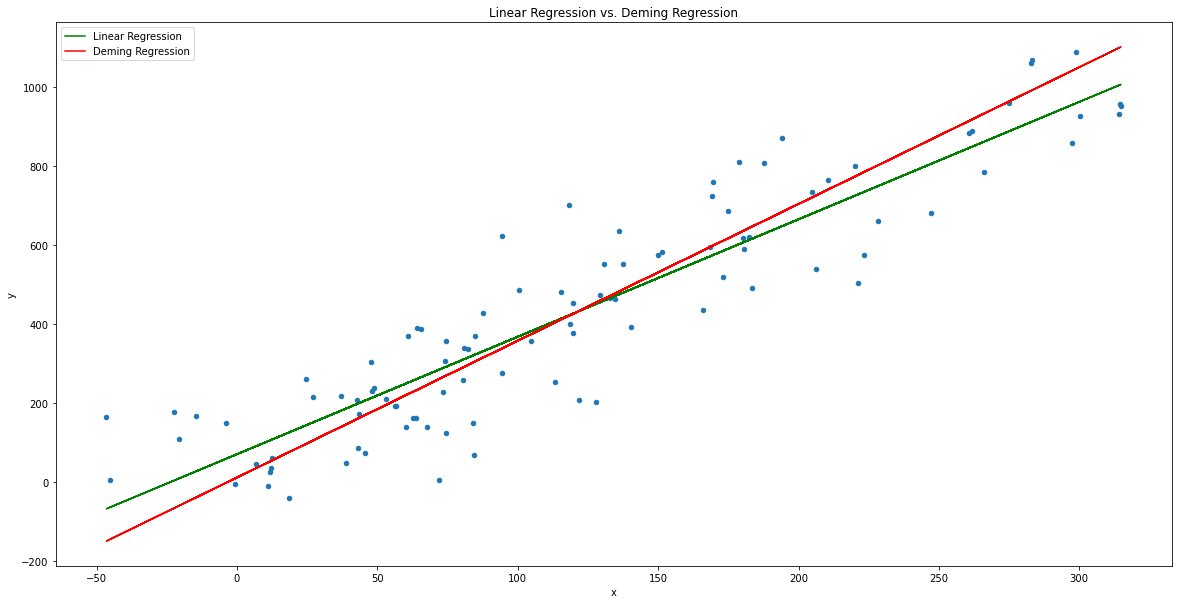

In [13]:
data.plot.scatter('x', 'y')
plt.plot(data.x, lin_reg.predict(data.x.values.reshape(-1, 1)), "g-", label='Linear Regression')
plt.plot(data.x, [slope * x_val + intercept for x_val in data.x], "r-", label='Deming Regression')
plt.legend()
plt.title('Linear Regression vs. Deming Regression')